In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mygrad.components as mc
import mygrad.functional as mf
from mygrad.losses import MeanSquareErrorLoss
from mygrad.optimizers import SGD, RMSProp
from mygrad.preprocessors import MinMaxScaler, StandardScaler, IdentityScaler
from mygrad.trainers import Trainer as RegressionTrainer, ProgressBar
from mygrad.dataloaders import NumpyRegressionDataloader

/tmp/ipykernel_7486/2770203544.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Steps large

In [2]:
train_df = pd.read_csv("../mio1/regression/steps-large-training.csv")
test_df = pd.read_csv("../mio1/regression/steps-large-test.csv")

In [3]:
X_train = train_df["x"].values
y_train = train_df["y"].values

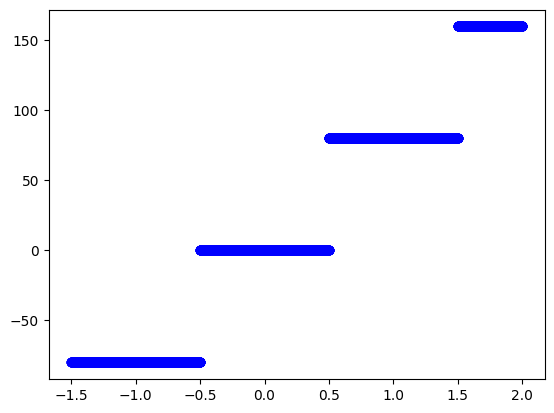

In [4]:
p = np.argsort(X_train)
plt.plot(X_train[p], y_train[p], "bo")

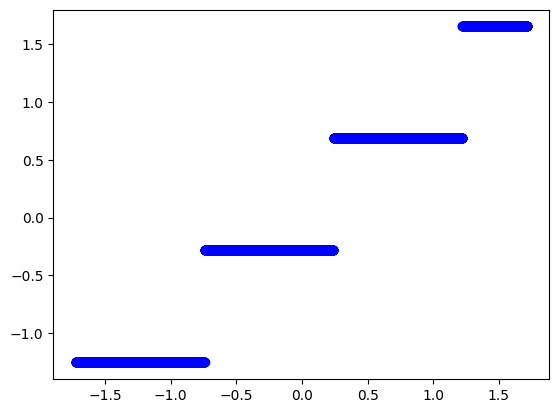

In [5]:
input_normalizer = StandardScaler()
output_normalizer = StandardScaler()

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

X_train_scaled = input_normalizer.fit_transform(X_train)
y_train_scaled = output_normalizer.fit_transform(y_train)

plt.plot(X_train_scaled[p, :], y_train_scaled[p, :], "bo")

In [6]:
len(X_train)

10000

## SGD

In [7]:
model = mc.Sequential(
    mc.Linear(1, 30, init="he"),
    mc.ReLU(),
    mc.Linear(30, 30, init="he"),
    mc.ReLU(),
    mc.Linear(30, 30, init="he"),
    mc.ReLU(),
    mc.Linear(30, 30, init="he"),
    mc.ReLU(),
    mc.Linear(30, 1, init="uniform"),
)
optimizer = SGD(model.parameters(), learning_rate=0.01, momentum=0.5, dampening=0.5)
loss = MeanSquareErrorLoss()
train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train_scaled, batch_size=10, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_losses_sgd = trainer.train(200)["loss"]

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

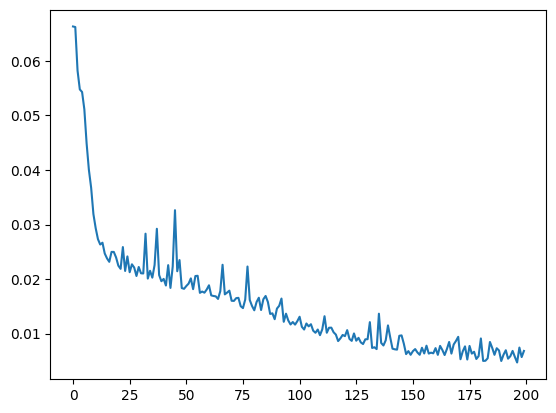

In [8]:
plt.plot(train_losses_sgd)

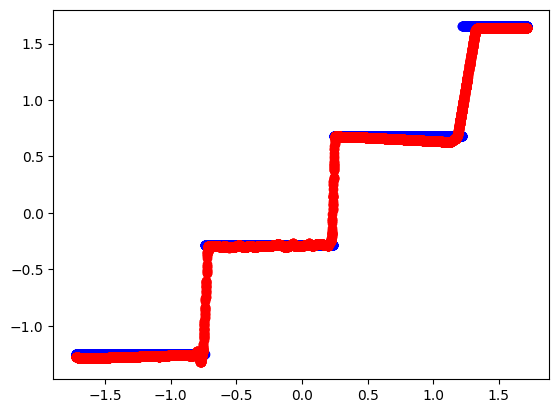

In [9]:
y_pred = model.forward(X_train_scaled)
plt.plot(X_train_scaled, y_train_scaled, "bo")
plt.plot(X_train_scaled, y_pred, "ro")


MSE: [58.17462144]


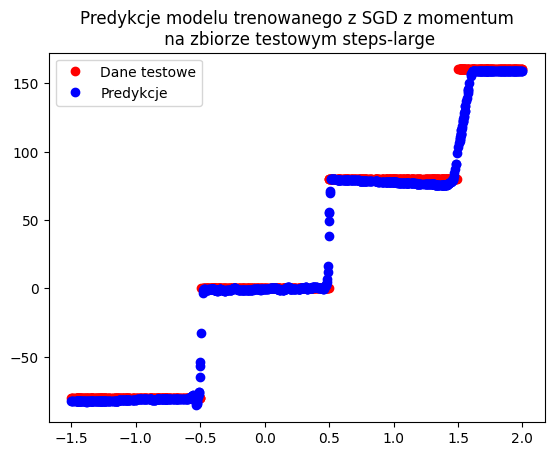

In [10]:
X_test = test_df["x"].values.reshape(-1, 1)
y_test = test_df["y"].values.reshape(-1, 1)

X_test_scaled = input_normalizer.transform(X_test)

y_pred_scaled = model.forward(X_test_scaled)
y_pred = output_normalizer.reverse(y_pred_scaled)

# plt.plot(X_test, y_test, "bo")
# plt.plot(X_test, y_pred, "ro")

print(f"MSE: {mf.mse(y_pred, y_test)}")

plt.plot(X_test, y_test, "ro", label="Dane testowe")
plt.plot(X_test, y_pred, "bo", label="Predykcje")
plt.title("Predykcje modelu trenowanego z SGD z momentum\n na zbiorze testowym steps-large")
plt.legend()

## RMSProp

In [11]:
model = mc.Sequential(
    mc.Linear(1, 30, init="he"),
    mc.ReLU(),
    mc.Linear(30, 30, init="he"),
    mc.ReLU(),
    mc.Linear(30, 1, init="uniform"),
)
optimizer = RMSProp(model.parameters(), learning_rate=0.005, beta=0.8)
loss = MeanSquareErrorLoss()
train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train_scaled, batch_size=20, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_losses_rms = trainer.train(200)["loss"]

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
optimizer = SGD(model.parameters(), learning_rate=0.005)
loss = MeanSquareErrorLoss()
train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train_scaled, batch_size=10000, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_losses = trainer.train(1000)["loss"]

Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

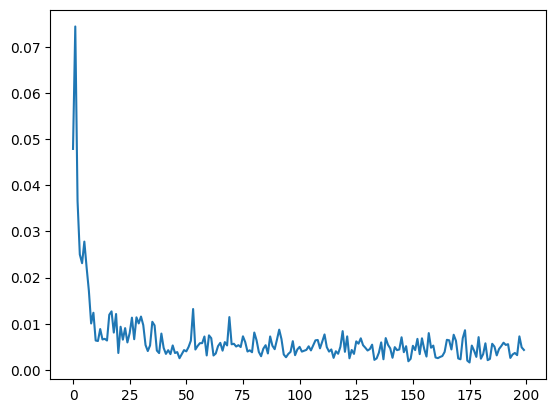

In [13]:
plt.plot(train_losses_rms)

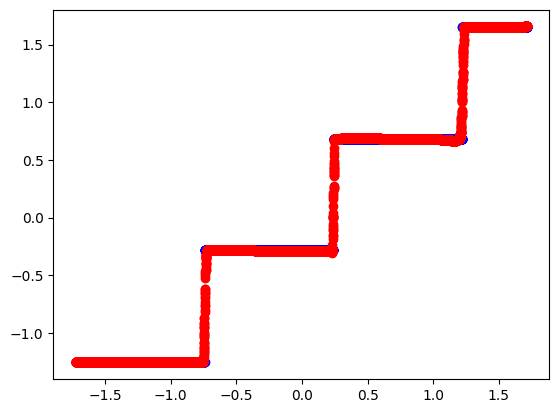

In [14]:
y_pred = model.forward(X_train_scaled)
plt.plot(X_train_scaled, y_train_scaled, "bo")
plt.plot(X_train_scaled, y_pred, "ro")


MSE: [7.24738379]


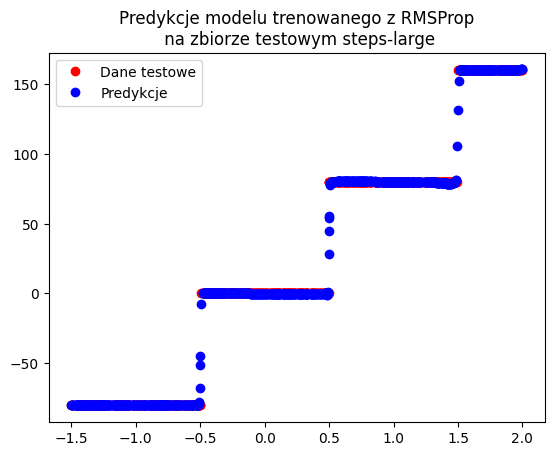

In [15]:
X_test = test_df["x"].values.reshape(-1, 1)
y_test = test_df["y"].values.reshape(-1, 1)

X_test_scaled = input_normalizer.transform(X_test)

y_pred_scaled = model.forward(X_test_scaled)
y_pred = output_normalizer.reverse(y_pred_scaled)

# plt.plot(X_test, y_test, "bo")
# plt.plot(X_test, y_pred, "ro")

print(f"MSE: {mf.mse(y_pred, y_test)}")

plt.plot(X_test, y_test, "ro", label="Dane testowe")
plt.plot(X_test, y_pred, "bo", label="Predykcje")
plt.title("Predykcje modelu trenowanego z RMSProp\n na zbiorze testowym steps-large")
plt.legend()

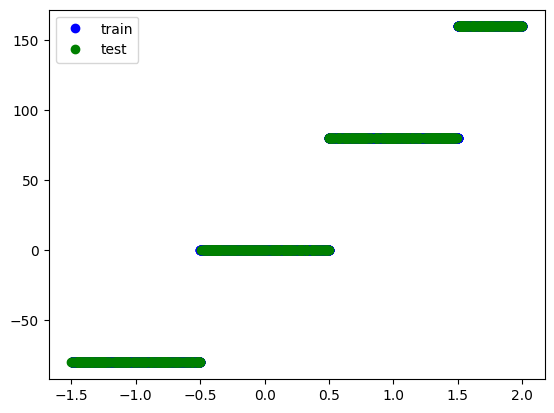

In [16]:
plt.plot(X_train, y_train, "bo", label="train")
plt.plot(X_test, y_test, "go", label="test")
plt.legend()

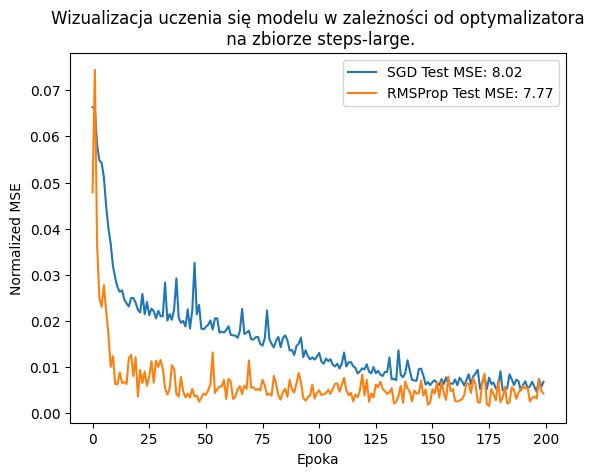

In [17]:
plt.plot(train_losses_sgd, label="SGD Test MSE: 8.02")
plt.plot(train_losses_rms, label="RMSProp Test MSE: 7.77")
plt.xlabel("Epoka")
plt.ylabel("Normalized MSE")
plt.legend()
plt.title("Wizualizacja uczenia się modelu w zależności od optymalizatora\n na zbiorze steps-large.")
plt.show()

## Only 1 layers

In [18]:
model = mc.Sequential(
    mc.Linear(1, 30, init="xavier"),
    mc.ReLU(),
    mc.Linear(30, 30, init="xavier"),
    mc.ReLU(),
    mc.Linear(30, 1, init="uniform"),
)
optimizer = RMSProp(model.parameters(), learning_rate=0.01, beta=0.9)
loss = MeanSquareErrorLoss()

train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train_scaled, batch_size=10, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader)
train_losses, _ = trainer.train(100)

ValueError: not enough values to unpack (expected 2, got 1)

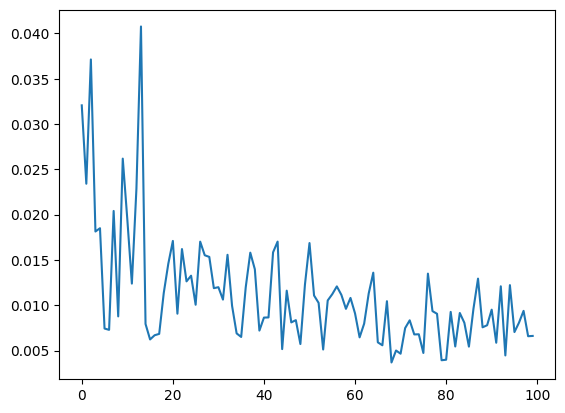

In [ ]:
plt.plot(train_losses)

In [ ]:
optimizer = RMSProp(model.parameters(), learning_rate=0.001, beta=0.7)
loss = MeanSquareErrorLoss()

train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train_scaled, batch_size=100, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader)
train_losses, _ = trainer.train(1000)

Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

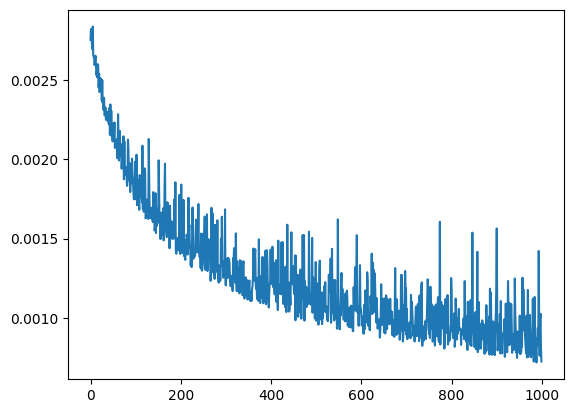

In [ ]:
plt.plot(train_losses)

MSE: [3.30656099]


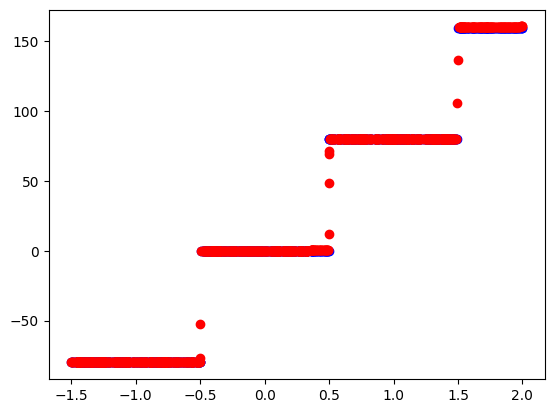

In [ ]:
X_test = test_df["x"].values.reshape(-1, 1)
y_test = test_df["y"].values.reshape(-1, 1)

X_test_scaled = input_normalizer.transform(X_test)

y_pred_scaled = model.forward(X_test_scaled)
y_pred = output_normalizer.reverse(y_pred_scaled)

plt.plot(X_test, y_test, "bo")
plt.plot(X_test, y_pred, "ro")

print(f"MSE: {mf.mse(y_pred, y_test)}")
